In [ ]:
import json
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd

In [ ]:



def load_activations_json(path: str | Path) -> Dict[str, Any]:
    """
    Load an activations_<split>.json file from evaluate_pointnet.py and convert to a convenient structure.

    Returns a dict:
    {
        "split": str,
        "accuracy": float,
        "records": List[{
            "batch_idx": int,
            "label": int,
            "logits": np.ndarray [C],
            "global_features": np.ndarray [256],
            "voxel_activations_3d": np.ndarray [G, G, G],
            "point_counts": np.ndarray [G^3],
            "indices": np.ndarray [N],
            "voxel_features": np.ndarray [C_feat, G, G, G],
            "grid_size": int
        }]
    }
    """
    path = Path(path)
    with path.open("r") as f:
        data = json.load(f)

    split = data.get("split", None)
    accuracy = data.get("accuracy", None)
    raw_records = data["records"]

    records: List[Dict[str, Any]] = []
    for r in raw_records:
        voxel_acts = np.array(r["voxel_activations_3d"], dtype=np.float32)  # [G,G,G]
        Gx, Gy, Gz = voxel_acts.shape
        assert Gx == Gy == Gz, "Expected cubic grid"
        G = Gx

        point_counts = np.array(r["point_counts"], dtype=np.int64)
        point_counts = point_counts.reshape(-1)  # [G^3]

        indices = np.array(r["indices"], dtype=np.int64)  # [N_points]
        logits = np.array(r["logits"], dtype=np.float32)  # [num_classes]
        global_features = np.array(r["global_features"], dtype=np.float32)  # [256]
        voxel_features = np.array(r["voxel_features"], dtype=np.float32)  # [C_feat,G,G,G]

        rec = {
            "batch_idx": int(r["batch_idx"]),
            "label": int(r["label"]),
            "logits": logits,
            "global_features": global_features,
            "voxel_activations_3d": voxel_acts,
            "point_counts": point_counts,
            "indices": indices,
            "voxel_features": voxel_features,
            "grid_size": G,
        }
        records.append(rec)

    dataset = {
        "split": split,
        "accuracy": accuracy,
        "records": records,
    }
    return dataset


def flat_to_xyz(flat_idx: int, grid_size: int) -> Tuple[int, int, int]:
    """
    Convert flat voxel index -> (x, y, z).

    Matches how VoxelAggregation flattens:
    idx = x * (G*G) + y * G + z
    which is exactly np.unravel_index with shape (G, G, G).
    """
    return tuple(int(v) for v in np.unravel_index(flat_idx, (grid_size, grid_size, grid_size)))


def xyz_to_flat(x: int, y: int, z: int, grid_size: int) -> int:
    """
    Convert (x,y,z) -> flat index.
    """
    return int(x * grid_size * grid_size + y * grid_size + z)

def get_top_k_voxels_for_record(
    rec: Dict[str, Any],
    k: int = 10,
    min_points: int = 1,
) -> pd.DataFrame:
    """
    For a single object (record), return a DataFrame with the top-k most active voxels.

    Columns:
        flat_idx, x, y, z, activation, point_count
    """
    G = rec["grid_size"]
    acts_3d = rec["voxel_activations_3d"]           
    counts_flat = rec["point_counts"]               

    acts_flat = acts_3d.reshape(-1)
    assert acts_flat.shape[0] == counts_flat.shape[0]

    mask_valid = counts_flat >= min_points
    if not np.any(mask_valid):
        return pd.DataFrame(columns=["flat_idx", "x", "y", "z", "activation", "point_count"])

    masked_acts = acts_flat.copy()
    masked_acts[~mask_valid] = -np.inf

    order = np.argsort(masked_acts)[::-1]
    order = order[mask_valid[order]]
    order = order[:k]

    xs, ys, zs = np.unravel_index(order, (G, G, G))

    df = pd.DataFrame({
        "flat_idx": order,
        "x": xs,
        "y": ys,
        "z": zs,
        "activation": acts_flat[order],
        "point_count": counts_flat[order],
    }).reset_index(drop=True)

    return df


def summarize_object_voxels(
    rec: Dict[str, Any],
    min_points: int = 1,
) -> Dict[str, Any]:
    """
    Returns some summary statistics for a single object:
    - fraction of non-empty voxels
    - mean / std point count (non-empty)
    - mean activation (all / non-empty)
    - correlation between activation and point count
    """
    G = rec["grid_size"]
    acts_3d = rec["voxel_activations_3d"]
    counts_flat = rec["point_counts"]    
    acts_flat = acts_3d.reshape(-1)      

    non_empty_mask = counts_flat >= min_points

    num_voxels = counts_flat.size
    num_non_empty = int(non_empty_mask.sum())
    frac_non_empty = num_non_empty / num_voxels

    stats = {
        "grid_size": G,
        "num_voxels": num_voxels,
        "num_non_empty": num_non_empty,
        "fraction_non_empty": frac_non_empty,
        "mean_point_count_non_empty": float(counts_flat[non_empty_mask].mean()) if num_non_empty > 0 else 0.0,
        "std_point_count_non_empty": float(counts_flat[non_empty_mask].std()) if num_non_empty > 0 else 0.0,
        "mean_activation_all": float(acts_flat.mean()),
        "std_activation_all": float(acts_flat.std()),
        "mean_activation_non_empty": float(acts_flat[non_empty_mask].mean()) if num_non_empty > 0 else float("nan"),
        "std_activation_non_empty": float(acts_flat[non_empty_mask].std()) if num_non_empty > 0 else float("nan"),
    }

    if num_non_empty > 1:
        x = acts_flat[non_empty_mask]
        y = np.log1p(counts_flat[non_empty_mask].astype(np.float32))
        cov = np.cov(x, y)
        var_x = cov[0, 0]
        var_y = cov[1, 1]
        cov_xy = cov[0, 1]
        if var_x > 0 and var_y > 0:
            corr = cov_xy / np.sqrt(var_x * var_y)
        else:
            corr = np.nan
        stats["corr_activation_log_points_non_empty"] = float(corr)
    else:
        stats["corr_activation_log_points_non_empty"] = float("nan")

    return stats


def top_k_statistics_across_objects(
    records: List[Dict[str, Any]],
    k: int = 10,
    min_points: int = 1,
) -> pd.DataFrame:
    """
    For each object, take top-k voxels by activation (with >= min_points),
    then aggregate across all objects.

    Returns a DataFrame with columns:
        flat_idx, x, y, z,
        times_in_top_k, frac_objects,
        mean_activation, std_activation, min_activation, max_activation,
        mean_point_count, std_point_count, min_point_count, max_point_count
    """
    if not records:
        return pd.DataFrame()

    G = records[0]["grid_size"]
    num_objects = len(records)

    stats: Dict[int, Dict[str, Any]] = {}

    for rec in records:
        df_top = get_top_k_voxels_for_record(rec, k=k, min_points=min_points)
        if df_top.empty:
            continue

        for _, row in df_top.iterrows():
            idx = int(row["flat_idx"])
            act = float(row["activation"])
            cnt = float(row["point_count"])

            if idx not in stats:
                stats[idx] = {
                    "flat_idx": idx,
                    "x": int(row["x"]),
                    "y": int(row["y"]),
                    "z": int(row["z"]),
                    "times_in_top_k": 0,
                    "activation_values": [],  
                    "point_count_values": [], 
                }
            
            stats[idx]["times_in_top_k"] += 1
            stats[idx]["activation_values"].append(act)
            stats[idx]["point_count_values"].append(cnt)

    if not stats:
        return pd.DataFrame(columns=[
            "flat_idx", "x", "y", "z",
            "times_in_top_k", "frac_objects",
            "mean_activation", "std_activation", "min_activation", "max_activation",
            "mean_point_count", "std_point_count", "min_point_count", "max_point_count",
        ])

    rows = []
    for idx, s in stats.items():
        acts = np.array(s["activation_values"], dtype=float)
        cnts = np.array(s["point_count_values"], dtype=float)

        rows.append({
            "flat_idx": s["flat_idx"],
            "x": s["x"],
            "y": s["y"],
            "z": s["z"],
            "times_in_top_k": s["times_in_top_k"],
            "frac_objects": s["times_in_top_k"] / num_objects,
            
            # Activation stats
            "mean_activation": float(acts.mean()),
            "std_activation": float(acts.std()),
            "min_activation": float(acts.min()),
            "max_activation": float(acts.max()),

            # Point count stats
            "mean_point_count": float(cnts.mean()),
            "std_point_count": float(cnts.std()),
            "min_point_count": float(cnts.min()),
            "max_point_count": float(cnts.max()),
        })

    df = pd.DataFrame(rows).sort_values("times_in_top_k", ascending=False).reset_index(drop=True)
    return df


def overall_point_count_distribution(
    records: List[Dict[str, Any]],
    min_points: int = 1,
    num_bins: int = 20,
) -> Dict[str, Any]:
    """
    Aggregate the distribution of point counts across ALL voxels of ALL objects.

    Returns:
        {
            "hist_counts": np.ndarray (histogram values),
            "hist_bin_edges": np.ndarray,
            "mean_points_per_voxel": float,
            "mean_points_per_non_empty_voxel": float,
            "fraction_non_empty_voxels": float
        }
    """
    if not records:
        return {}

    all_counts = []
    for rec in records:
        all_counts.append(rec["point_counts"])
    all_counts = np.concatenate(all_counts, axis=0) 

    mean_points = float(all_counts.mean())
    non_empty_mask = all_counts >= min_points
    if np.any(non_empty_mask):
        mean_points_non_empty = float(all_counts[non_empty_mask].mean())
        frac_non_empty = float(non_empty_mask.mean())
    else:
        mean_points_non_empty = 0.0
        frac_non_empty = 0.0

    hist, edges = np.histogram(all_counts, bins=num_bins)

    return {
        "hist_counts": hist,
        "hist_bin_edges": edges,
        "mean_points_per_voxel": mean_points,
        "mean_points_per_non_empty_voxel": mean_points_non_empty,
        "fraction_non_empty_voxels": frac_non_empty,
    }


def summarize_activation_pointcount_correlation(records: List[Dict[str, Any]], min_points: int = 1) -> pd.DataFrame:
    """
    Compute activation vs point-count correlation per object and summarize as a table.

    Returns DataFrame with one row per object:
        object_idx, label, corr_activation_log_points_non_empty, fraction_non_empty, mean_point_count_non_empty
    """
    rows = []
    for i, rec in enumerate(records):
        stats = summarize_object_voxels(rec, min_points=min_points)
        rows.append({
            "object_idx": i,
            "label": rec["label"],
            "fraction_non_empty": stats["fraction_non_empty"],
            "mean_point_count_non_empty": stats["mean_point_count_non_empty"],
            "corr_activation_log_points_non_empty": stats["corr_activation_log_points_non_empty"],
        })
    return pd.DataFrame(rows)



In [ ]:

json_path = "../activations_out/dominik_model/train_random.json"

dataset = load_activations_json(json_path)
records = dataset["records"]
print(f"Loaded split={dataset['split']}, accuracy={dataset['accuracy']}, num_records={len(records)}")


Loaded split=train, accuracy=0.9835164835164835, num_records=364


In [ ]:
rec0 = records[10]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_activation_distribution_record(
    rec,
    bins: int = 50,
    non_empty_only: bool = False,
    min_points: int = 1,
    log_y: bool = False,
    title_prefix: str = "Activation distribution (object)",
):
    """
    Plot histogram of voxel activations for a single object.

    Args:
        rec: one record from `records`
        bins: histogram bins
        non_empty_only: if True, only consider voxels with >= min_points points
        min_points: threshold for "non-empty"
        log_y: if True, use log-scale on y-axis
    """
    acts = rec["voxel_activations_3d"].reshape(-1)      
    counts = rec["point_counts"]                        

    if non_empty_only:
        mask = counts >= min_points
        acts = acts[mask]

    plt.figure()
    plt.hist(acts, bins=bins)
    plt.xlabel("voxel activation")
    plt.ylabel("count")
    if log_y:
        plt.yscale("log")
    plt.title(f"{title_prefix} | label={rec['label']} | non_empty_only={non_empty_only}")
    plt.show()


def plot_activation_distribution_dataset(
    records,
    bins: int = 50,
    non_empty_only: bool = False,
    min_points: int = 1,
    log_y: bool = False,
    max_objects: int | None = None,
    title: str = "Activation distribution (dataset)",
):
    """
    Plot histogram of voxel activations aggregated over many objects.
    """
    all_acts = []

    for i, rec in enumerate(records):
        if max_objects is not None and i >= max_objects:
            break
        acts = rec["voxel_activations_3d"].reshape(-1)   # [G^3]
        counts = rec["point_counts"]
        if non_empty_only:
            mask = counts >= min_points
            acts = acts[mask]
        all_acts.append(acts)

    if not all_acts:
        print("No records to plot.")
        return

    all_acts = np.concatenate(all_acts, axis=0)

    plt.figure()
    plt.hist(all_acts, bins=bins)
    plt.xlabel("voxel activation")
    plt.ylabel("count")
    if log_y:
        plt.yscale("log")
    plt.title(title + f" | non_empty_only={non_empty_only}")
    plt.show()


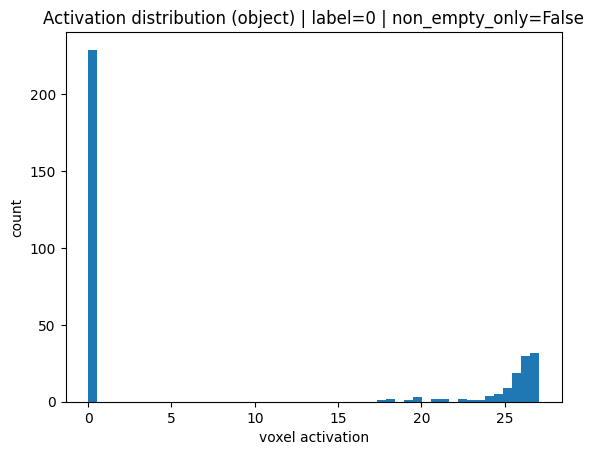

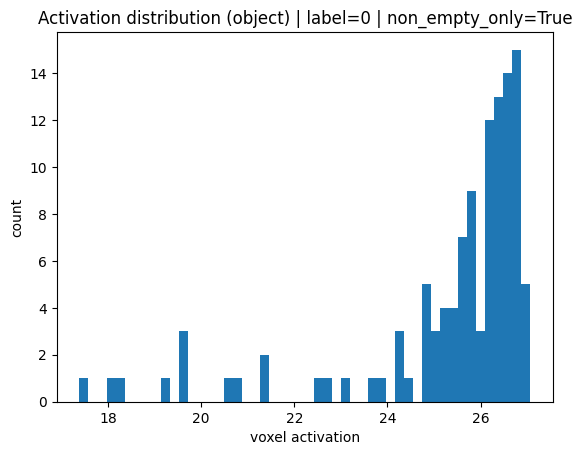

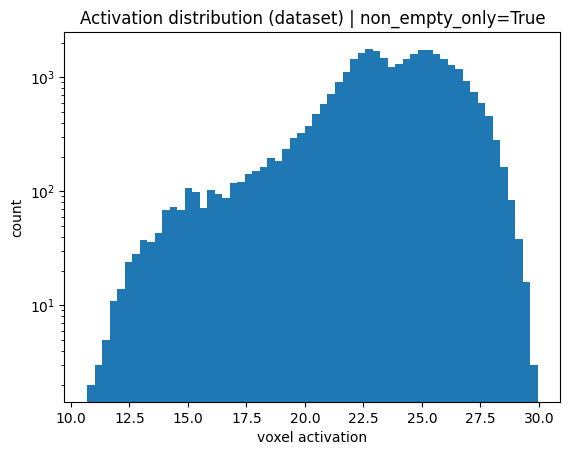

In [ ]:
plot_activation_distribution_record(rec0, bins=50, non_empty_only=False)

plot_activation_distribution_record(rec0, bins=50, non_empty_only=True, min_points=1)



In [ ]:
def plot_activation_vs_pointcount_record(
    rec,
    min_points: int = 1,
    log_points: bool = True,
    log_activations: bool = False,
    bins: int = 50,
    kind: str = "hexbin",
    title_prefix: str = "Activation vs point count (object)",
):
    """
    Plot 2D distribution of (activation, point_count) for one object.

    Args:
        rec: one record from `records`
        min_points: consider only voxels with >= min_points points
        log_points: if True, use log(1 + point_count) for x-axis
        log_activations: if True, use log(1 + activation) for y-axis
        bins: number of bins for hist2d / resolution for hexbin
        kind: "hexbin" or "hist2d"
    """
    acts = rec["voxel_activations_3d"].reshape(-1) 
    counts = rec["point_counts"].astype(np.float32)

    mask = counts >= min_points
    if not np.any(mask):
        print("No voxels with >= min_points.")
        return

    acts = acts[mask]
    counts = counts[mask]

    if log_points:
        x = np.log1p(counts)
        x_label = "log(1 + point_count)"
    else:
        x = counts
        x_label = "point_count"

    if log_activations:
        y = np.log1p(np.maximum(acts, 0.0))
        y_label = "log(1 + activation)"
    else:
        y = acts
        y_label = "activation"

    plt.figure()
    if kind == "hexbin":
        plt.hexbin(x, y, gridsize=bins)
        plt.colorbar(label="count")
    else:
        plt.hist2d(x, y, bins=bins)
        plt.colorbar(label="count")

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{title_prefix} | label={rec['label']}")
    plt.show()


def plot_activation_vs_pointcount_dataset(
    records,
    min_points: int = 1,
    log_points: bool = True,
    log_activations: bool = False,
    bins: int = 50,
    kind: str = "hexbin",
    max_objects: int | None = None,
    sample_voxels: int | None = 200_000,
    title: str = "Activation vs point count (dataset)",
):
    """
    Plot 2D distribution of (activation, point_count) aggregated over many objects.

    Args:
        sample_voxels: if not None, randomly subsample this many voxels for plotting
                       (useful to avoid plotting millions of points)
    """
    xs = []
    ys = []

    rng = np.random.default_rng(0)

    for i, rec in enumerate(records):
        if max_objects is not None and i >= max_objects:
            break

        acts = rec["voxel_activations_3d"].reshape(-1)
        counts = rec["point_counts"].astype(np.float32)

        mask = counts >= min_points
        if not np.any(mask):
            continue

        acts = acts[mask]
        counts = counts[mask]

        if log_points:
            x = np.log1p(counts)
        else:
            x = counts

        if log_activations:
            y = np.log1p(np.maximum(acts, 0.0))
        else:
            y = acts

        xs.append(x)
        ys.append(y)

    if not xs:
        print("No data to plot.")
        return

    x_all = np.concatenate(xs, axis=0)
    y_all = np.concatenate(ys, axis=0)

    if sample_voxels is not None and x_all.shape[0] > sample_voxels:
        idx = rng.choice(x_all.shape[0], size=sample_voxels, replace=False)
        x_all = x_all[idx]
        y_all = y_all[idx]

    plt.figure()
    if kind == "hexbin":
        plt.hexbin(x_all, y_all, gridsize=bins)
        plt.colorbar(label="count")
    else:
        plt.hist2d(x_all, y_all, bins=bins)
        plt.colorbar(label="count")

    x_label = "log(1 + point_count)" if log_points else "point_count"
    y_label = "log(1 + activation)" if log_activations else "activation"

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


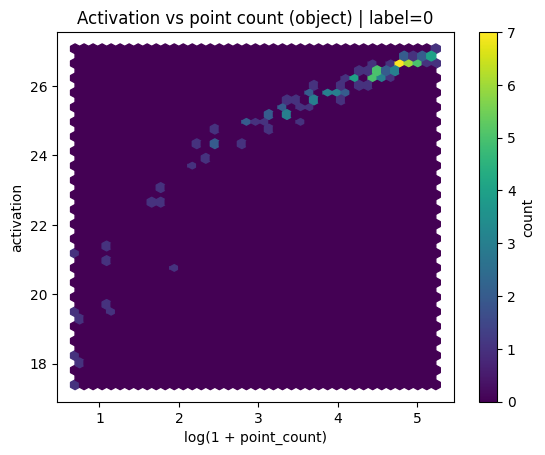

In [ ]:
plot_activation_vs_pointcount_record(
    rec0,
    min_points=1,
    log_points=True,
    log_activations=False,
    bins=40,
    kind="hexbin",
)


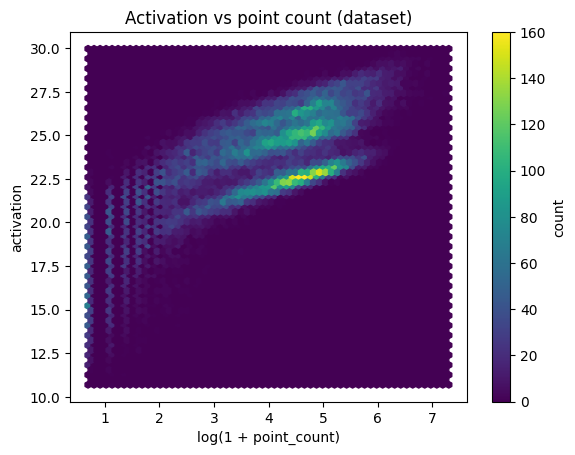

In [ ]:

plot_activation_vs_pointcount_dataset(
    records,
    min_points=1,
    log_points=True,
    log_activations=False,
    bins=60,
    kind="hexbin",
    sample_voxels=100_000,
)


In [ ]:

stats0 = summarize_object_voxels(rec0, min_points=1)
print("\nObject 0 voxel summary:")
for k, v in stats0.items():
    print(f"  {k}: {v}")




Object 0 voxel summary:
  grid_size: 7
  num_voxels: 343
  num_non_empty: 114
  fraction_non_empty: 0.3323615160349854
  mean_point_count_non_empty: 71.85964912280701
  std_point_count_non_empty: 52.990213792469476
  mean_activation_all: 8.415761947631836
  std_activation_all: 11.988729476928711
  mean_activation_non_empty: 25.321109771728516
  std_activation_non_empty: 2.094663619995117
  corr_activation_log_points_non_empty: 0.9362106375205266


# SECTION 2

# WHICH VOXELS ARE TOP ACTIVE

In [ ]:
df_top_global = top_k_statistics_across_objects(records, k=10, min_points=1)
print("\nMost frequently top-active voxels across objects:")
df_top_global.head(40)



Most frequently top-active voxels across objects:


,flat_idx,x,y,z,times_in_top_k,frac_objects,mean_activation,std_activation,min_activation,max_activation,mean_point_count,std_point_count,min_point_count,max_point_count
0,171,3,3,3,137,0.376374,26.068913,2.085002,22.475687,29.682726,358.846715,179.955667,101.0,990.0
1,170,3,3,2,121,0.332418,25.807953,2.057458,22.607590,29.302532,300.834711,140.315662,105.0,757.0
2,115,2,2,3,99,0.271978,26.226076,1.875875,22.855618,29.206970,322.969697,131.857855,121.0,647.0
3,226,4,4,2,82,0.225275,26.121778,2.145301,22.843044,29.372812,301.939024,153.759421,129.0,836.0
4,164,3,2,3,73,0.200549,24.627705,1.553776,22.750971,28.672821,246.506849,80.370056,126.0,483.0
5,114,2,2,2,72,0.197802,26.687511,1.324584,23.066601,29.166199,309.555556,138.446429,142.0,716.0
6,116,2,2,4,69,0.189560,26.700070,1.917972,23.008663,29.570705,348.826087,168.782079,152.0,893.0
7,172,3,3,4,63,0.173077,26.927662,1.220072,23.754185,29.487135,307.920635,110.362937,125.0,606.0
8,220,4,3,3,59,0.162088,25.429100,1.497450,22.620174,28.535311,278.440678,90.681837,107.0,519.0
9,227,4,4,3,57,0.156593,26.820346,1.654399,22.557470,29.506598,333.228070,179.151804,130.0,1106.0


In [ ]:

pc_stats = overall_point_count_distribution(records, min_points=1, num_bins=20)
print("\nOverall point-count distribution:")
print(f"  mean_points_per_voxel:          {pc_stats['mean_points_per_voxel']}")
print(f"  mean_points_per_non_empty_voxel:{pc_stats['mean_points_per_non_empty_voxel']}")
print(f"  fraction_non_empty_voxels:      {pc_stats['fraction_non_empty_voxels']}")



Overall point-count distribution:
  mean_points_per_voxel:          23.88338192419825
  mean_points_per_non_empty_voxel:90.30551181102362
  fraction_non_empty_voxels:      0.2644731361932528


In [ ]:

df_corr = summarize_activation_pointcount_correlation(records, min_points=1)
print("\nPer-object activation vs point-count correlation:")
display(df_corr.head())


Per-object activation vs point-count correlation:


,object_idx,label,fraction_non_empty,mean_point_count_non_empty,corr_activation_log_points_non_empty
0,0,4,0.411079,58.099291,0.863993
1,1,6,0.309038,77.283019,0.927839
2,2,7,0.268222,89.043478,0.891721
3,3,5,0.244898,97.523810,0.949440
4,4,3,0.172012,138.847458,0.922247


# ANALYSIS OF CHANNELS BUT AT THE VOXEL LEVEL

In [ ]:
def plot_channel_distribution_for_record(
    rec,
    channel: int,
    min_points: int = 1,
    non_empty_only: bool = True,
    bins: int = 50,
    log_y: bool = False,
    label: str | None = None,
):
    """
    For one record and one channel:
      - Plot distribution of voxel_features[channel, x, y, z] across all voxels
      - Compare with the same channel's value in global_features (vertical line)

    Args:
        channel: int, channel index (0..C-1)
        min_points: minimum points in voxel if non_empty_only=True
        non_empty_only: if True, ignore voxels with < min_points
        bins: histogram bins
        log_y: if True, log-scale y-axis
    """
    voxel_features = rec["voxel_features"]     
    point_counts = rec["point_counts"]         
    global_features = rec["global_features"]   
    G = rec["grid_size"]

    C = voxel_features.shape[0]
    if channel < 0 or channel >= C:
        raise ValueError(f"channel {channel} out of range [0, {C-1}]")

    chan_vals = voxel_features[channel].reshape(-1)   # [G^3]

    if non_empty_only:
        mask = point_counts >= min_points
        chan_vals = chan_vals[mask]

    if chan_vals.size == 0:
        print("No voxels passed the filter; nothing to plot.")
        return

    gf_val = float(global_features[channel])

    if label is None:
        label = f"record_label={rec['label']}"

    plt.figure(figsize=(7, 4))
    plt.hist(chan_vals, bins=bins, alpha=0.8)
    plt.axvline(gf_val, linestyle="--", linewidth=2, label=f"global_feature[{channel}] = {gf_val:.4f}")
    plt.xlabel(f"voxel_features[channel={channel}]")
    plt.ylabel("count")
    if log_y:
        plt.yscale("log")
    plt.title(f"Channel {channel} distribution across voxels | {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    stats = {
        "channel": channel,
        "global_feature_value": gf_val,
        "mean_voxel_value": float(chan_vals.mean()),
        "std_voxel_value": float(chan_vals.std()),
        "min_voxel_value": float(chan_vals.min()),
        "max_voxel_value": float(chan_vals.max()),
        "num_voxels_used": int(chan_vals.size),
    }

    print("Channel distribution stats:")
    for k, v in stats.items():
        print(f"  {k}: {v}")

    return stats


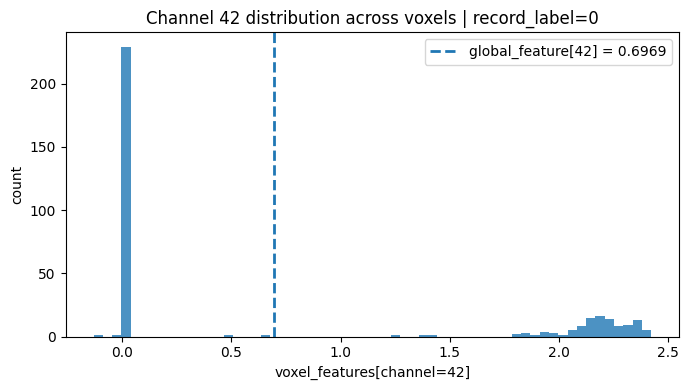

Channel distribution stats:
  channel: 42
  global_feature_value: 0.6969165205955505
  mean_voxel_value: 0.6969165205955505
  std_voxel_value: 1.0150243043899536
  min_voxel_value: -0.13239553570747375
  max_voxel_value: 2.424358606338501
  num_voxels_used: 343


In [ ]:
channel_to_inspect = 42

_ = plot_channel_distribution_for_record(
    rec0,
    channel=channel_to_inspect,
    min_points=1,
    non_empty_only=True,
    bins=60,
    log_y=False,
)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def topk_channels_per_voxel_record(rec, k: int = 5) -> pd.DataFrame:
    """
    For a single record (object):

    For every voxel, finds the K most active channels in the voxel feature vector
    (size C, e.g. 256) and returns a DataFrame with:

        voxel_idx  (flat index, 0..G^3-1)
        x, y, z    (voxel coordinates in grid)
        point_count
        channel_rank_0, activation_rank_0
        channel_rank_1, activation_rank_1
        ...
        channel_rank_{k-1}, activation_rank_{k-1}

    No voxel filtering is done here: ALL voxels are processed.
    """
    voxel_features = rec["voxel_features"]
    point_counts = rec["point_counts"]    
    G = rec["grid_size"]
    C = voxel_features.shape[0]

    assert voxel_features.shape == (C, G, G, G)
    assert point_counts.shape[0] == G**3

    rows = []
    num_voxels = G**3

    for flat_idx in range(num_voxels):
        x, y, z = np.unravel_index(flat_idx, (G, G, G))
        pc = int(point_counts[flat_idx])

        vec = voxel_features[:, x, y, z]

        if k >= C:
            top_channels = np.argsort(vec)[::-1]
        else:
            top_channels = np.argpartition(vec, -k)[-k:]
            top_channels = top_channels[np.argsort(vec[top_channels])[::-1]]

        row = {
            "voxel_idx": flat_idx,
            "x": x,
            "y": y,
            "z": z,
            "point_count": pc,
        }

        for r in range(k):
            ch_col = f"channel_rank_{r}"
            act_col = f"activation_rank_{r}"
            if r < len(top_channels):
                ch = int(top_channels[r])
                val = float(vec[ch])
                row[ch_col] = ch
                row[act_col] = val
            else:
                row[ch_col] = None
                row[act_col] = None

        rows.append(row)

    df = pd.DataFrame(rows)
    return df


In [32]:
rec0 = records[10]
df_voxel_topk = topk_channels_per_voxel_record(rec0, k=15)
df_sorted = df_voxel_topk.sort_values("activation_rank_0", ascending=False)
df_sorted.to_csv("voxel_topk_channels_record_NEW_pointnet_.csv", index=False)


In [19]:
df_sorted

,voxel_idx,x,y,z,point_count,channel_rank_0,activation_rank_0,channel_rank_1,activation_rank_1,channel_rank_2,...,channel_rank_10,activation_rank_10,channel_rank_11,activation_rank_11,channel_rank_12,activation_rank_12,channel_rank_13,activation_rank_13,channel_rank_14,activation_rank_14
121,121,2,3,2,123,219,4.533916,105,3.926609,92,...,132,3.285960,156,3.263994,85,3.253523,84,3.205367,164,3.202608
172,172,3,3,4,69,219,4.528407,92,3.859763,105,...,205,3.199794,132,3.172630,227,3.146302,84,3.124956,0,3.075592
72,72,1,3,2,186,219,4.522682,105,3.916522,92,...,100,3.387414,156,3.271078,85,3.251971,84,3.232723,164,3.192738
127,127,2,4,1,45,219,4.516173,196,3.772199,105,...,85,3.182065,250,3.146514,205,3.140727,101,3.106110,138,3.096077
10,10,0,1,3,59,219,4.515752,92,3.835776,196,...,199,3.258837,100,3.220715,83,3.091845,84,3.055110,156,3.022440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,40,0,5,5,0,255,0.000000,254,0.000000,253,...,245,0.000000,244,0.000000,243,0.000000,242,0.000000,241,0.000000
41,41,0,5,6,0,255,0.000000,254,0.000000,253,...,245,0.000000,244,0.000000,243,0.000000,242,0.000000,241,0.000000
42,42,0,6,0,0,255,0.000000,254,0.000000,253,...,245,0.000000,244,0.000000,243,0.000000,242,0.000000,241,0.000000
43,43,0,6,1,0,255,0.000000,254,0.000000,253,...,245,0.000000,244,0.000000,243,0.000000,242,0.000000,241,0.000000


In [20]:
set_all = set()
for i in range(5):
    set_all = set_all.union(set(df_sorted[df_sorted[f'activation_rank_{i}'] > 0.0][f'channel_rank_{i}'].unique()))
set_all

{np.int64(18),
 np.int64(38),
 np.int64(83),
 np.int64(85),
 np.int64(92),
 np.int64(100),
 np.int64(101),
 np.int64(105),
 np.int64(132),
 np.int64(142),
 np.int64(156),
 np.int64(161),
 np.int64(164),
 np.int64(172),
 np.int64(196),
 np.int64(199),
 np.int64(205),
 np.int64(210),
 np.int64(218),
 np.int64(219),
 np.int64(226),
 np.int64(254)}

In [21]:
chan_act_list = [(idx, act) for idx, act in enumerate(rec0['global_features'])]
chan_act_list_sorted = sorted(chan_act_list, key=lambda x: x[1], reverse=True)
chan_act_list_sorted[:15]

[(219, np.float32(1.3706374)),
 (92, np.float32(1.1950308)),
 (196, np.float32(1.146294)),
 (105, np.float32(1.1199694)),
 (226, np.float32(1.0954816)),
 (100, np.float32(1.0781504)),
 (172, np.float32(1.071771)),
 (38, np.float32(1.0663772)),
 (199, np.float32(1.0482978)),
 (83, np.float32(0.9988489)),
 (205, np.float32(0.9946572)),
 (101, np.float32(0.98841953)),
 (85, np.float32(0.975618)),
 (164, np.float32(0.97550464)),
 (84, np.float32(0.9586434))]

In [ ]:
def plot_voxel_channel_heatmap(
    rec,
    include_empty: bool = True,
    min_points: int = 1,
    vmax: float | None = None,
    cmap: str = "viridis",
    title: str | None = None,
):
    """
    Heatmap where:
        x-axis: voxel id (flat index)
        y-axis: channel id
        color: voxel_features[channel, voxel]

    Args:
        include_empty: if True, include all voxels (0..G^3-1).
                       if False, include only voxels with point_count >= min_points.
        min_points: minimum number of points in a voxel when include_empty=False.
        vmax: optional upper limit for color scale (pass e.g. np.percentile(...)).
        cmap: matplotlib colormap name.
        title: optional plot title.
    """
    voxel_features = rec["voxel_features"]
    point_counts = rec["point_counts"]    
    G = rec["grid_size"]
    C = voxel_features.shape[0]

    feats_flat = voxel_features.reshape(C, -1) 
    num_voxels = feats_flat.shape[1]

    if include_empty:
        mask = np.ones(num_voxels, dtype=bool)
    else:
        mask = point_counts >= min_points

    if not np.any(mask):
        print("No voxels passed the min_points filter.")
        return

    feats_kept = feats_flat[:, mask]
    voxel_ids_kept = np.arange(num_voxels)[mask]

    plt.figure(figsize=(20, 8)) 
    im = plt.imshow(
        feats_kept,
        aspect="auto",
        interpolation="nearest",
        cmap=cmap,
        vmax=vmax,
    )
    plt.colorbar(im, label="activation")

    plt.ylabel("channel id")
    plt.xlabel("voxel id")

    num_xticks = 20
    idx_positions = np.linspace(0, feats_kept.shape[1] - 1, num_xticks, dtype=int)
    plt.xticks(
        ticks=idx_positions,
        labels=[str(voxel_ids_kept[i]) for i in idx_positions],
        rotation=90,
    )

    plt.yticks(
        ticks=np.linspace(0, C - 1, min(C, 16), dtype=int)
    )

    if title is None:
        title = f"Voxel-channel heatmap | label={rec['label']} | include_empty={include_empty}, min_points={min_points}"
    plt.title(title)

    plt.tight_layout()
    plt.show()


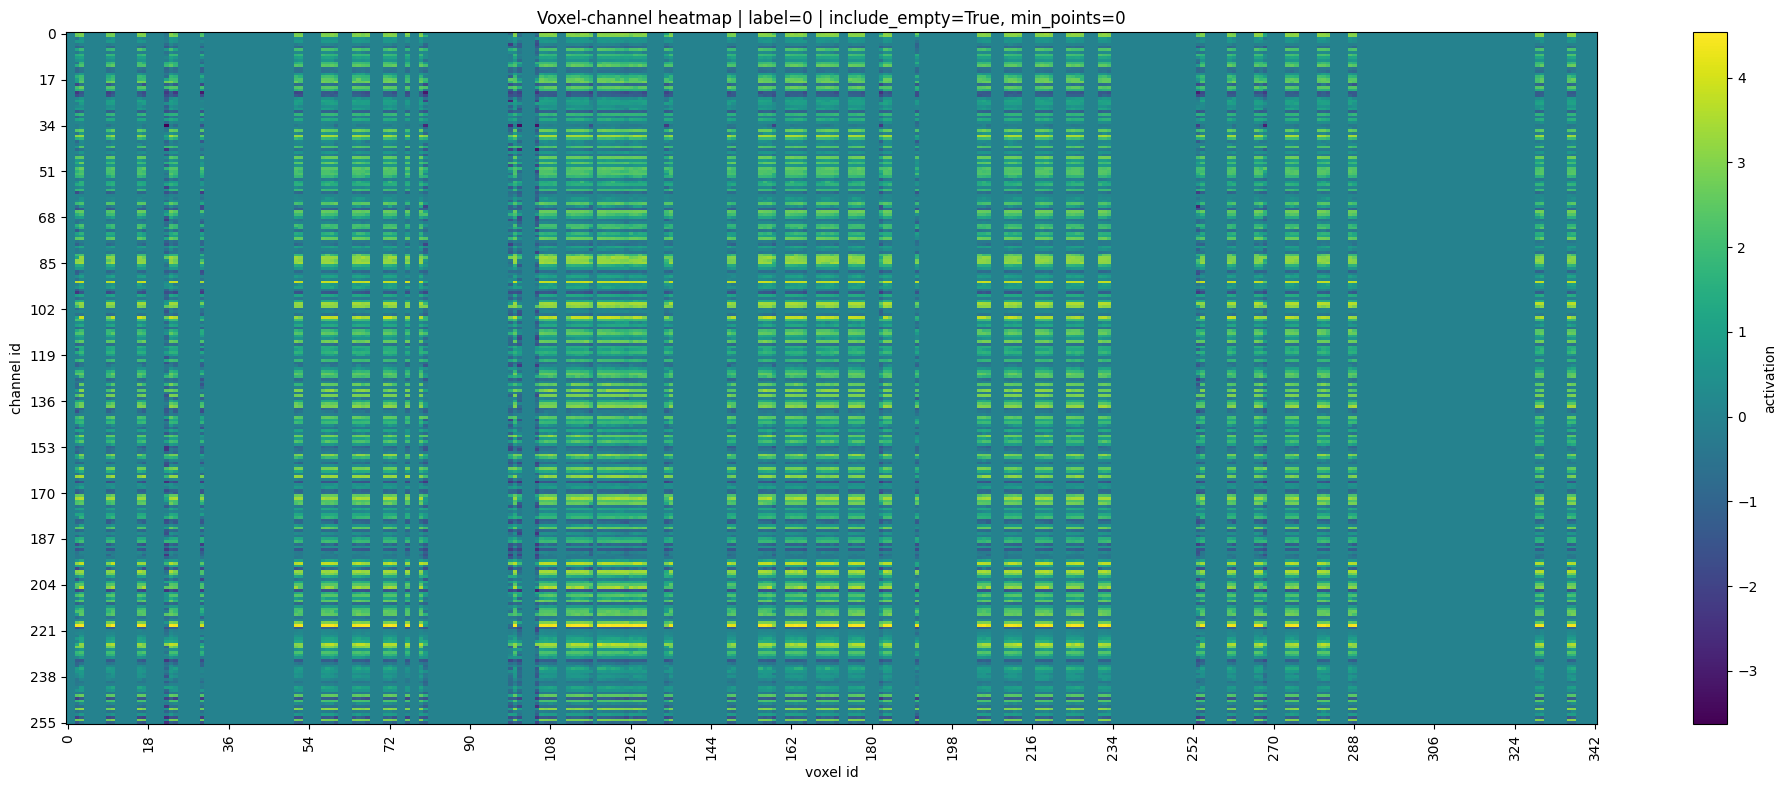

In [ ]:
plot_voxel_channel_heatmap(
    rec0,
    include_empty=True,
    min_points=0,
    cmap="viridis",
)


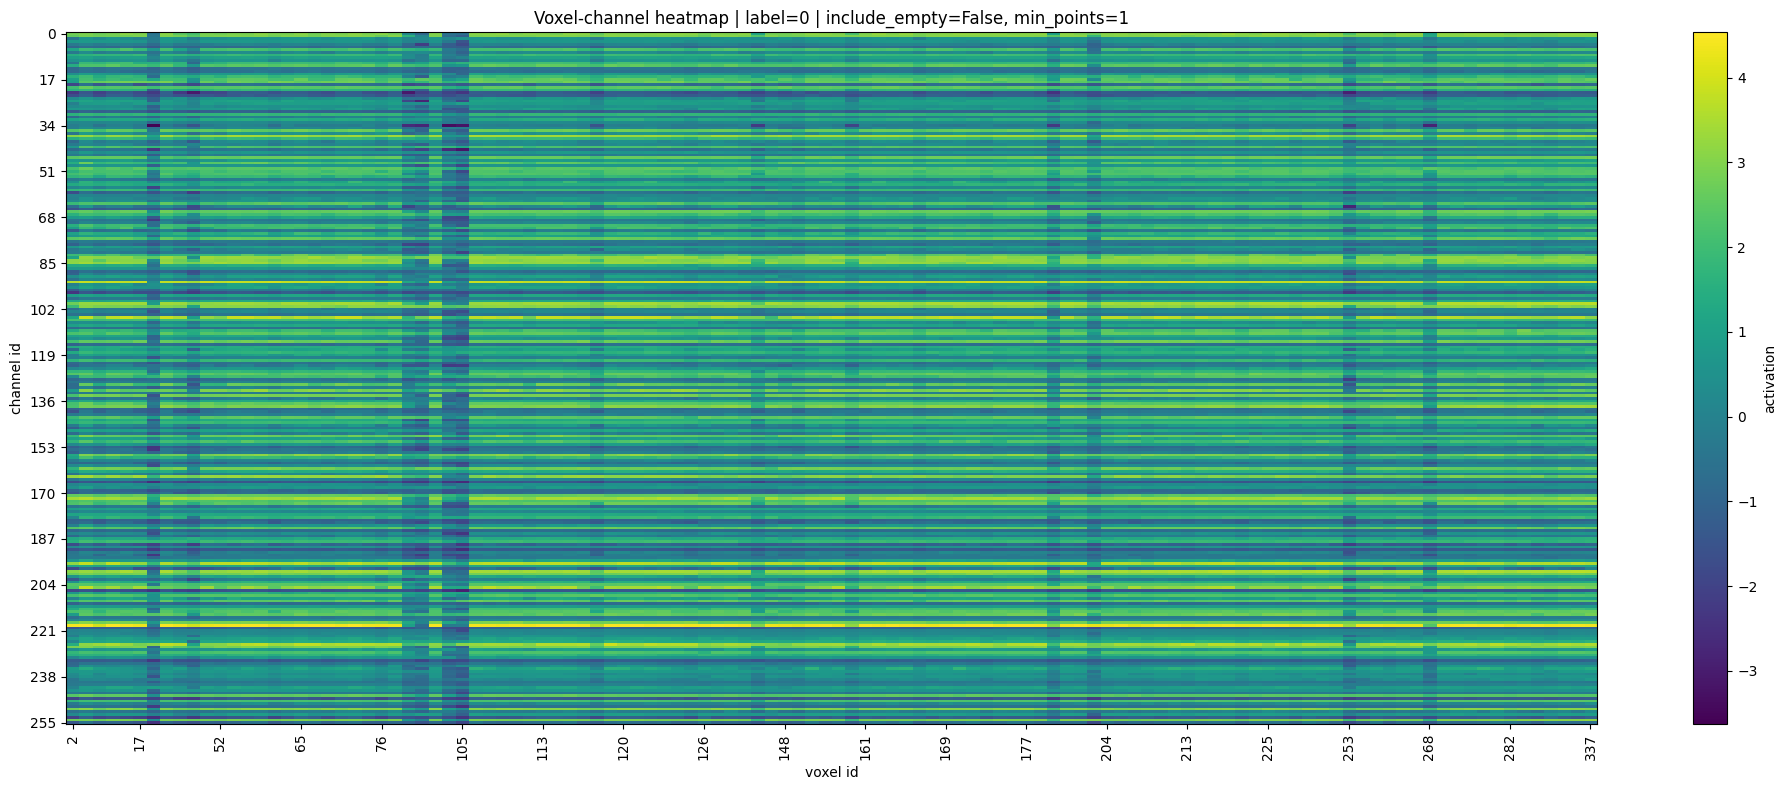

In [24]:
plot_voxel_channel_heatmap(
    rec0,
    include_empty=False,
    min_points=1,
    cmap="viridis",
)


In [25]:
rec0

{'batch_idx': 10,
 'label': 0,
 'logits': array([ 9.449423  , -1.0185205 ,  1.8850424 , -6.1884336 , -0.23971811,
        -0.6653379 , -2.7200098 , -6.1306915 ,  0.07294965], dtype=float32),
 'global_features': array([ 9.33933020e-01,  9.34823394e-01,  1.68023989e-01,  1.79106310e-01,
        -3.99687216e-02, -2.52942115e-01,  6.56799138e-01,  5.17856665e-02,
         5.85721970e-01,  3.32223982e-01,  1.72940433e-01,  5.88375390e-01,
         7.67205358e-01, -1.63951978e-01, -1.96963444e-01,  2.26205468e-01,
         5.62159359e-01,  7.34337330e-01,  8.25242519e-01, -2.71933377e-01,
         7.84251630e-01,  4.83791798e-01, -4.96475548e-01, -4.09275919e-01,
         1.57687113e-01,  2.72502244e-01,  2.96021253e-01,  1.41072825e-01,
         2.48221621e-01, -3.52040619e-01,  5.57691395e-01, -5.63259497e-02,
         4.41400319e-01,  7.10184425e-02, -1.40619040e-01,  9.40732844e-03,
         7.76390612e-01,  1.13925591e-01,  1.06637716e+00,  5.84653914e-01,
         3.49612162e-02,  4.46

In [33]:
point_counts_1 = [idx for idx, numeber in enumerate(rec0['point_counts']) if numeber == 1]

In [34]:
point_counts_1

[22, 80, 99, 101, 105, 253]

In [ ]:
def plot_voxel_channel_heatmap_subset(
    rec,
    voxel_indices: list[int] | None = None,
    channel_indices: list[int] | None = None,
    include_empty: bool = True,
    min_points: int = 1,
    vmax: float | None = None,
    cmap: str = "viridis",
    title: str | None = None,
):
    """
    Heatmap where:
        x-axis: selected voxel ids (flat indices)
        y-axis: selected channel ids
        color: voxel_features[channel, voxel]

    Args:
        rec: single record dict
        voxel_indices: optional list of voxel indices (flat 0..G^3-1).
                       If None, use all voxels (optionally filtered by include_empty/min_points).
        channel_indices: optional list of channel indices (0..C-1).
                         If None, use all channels.
        include_empty: if True and voxel_indices is None, include all voxels.
                       if False and voxel_indices is None, filter by min_points.
                       If voxel_indices is not None, this flag still applies as an
                       additional filter (voxels below min_points can be dropped).
        min_points: minimum number of points in a voxel when include_empty=False.
        vmax: optional upper limit for color scale.
        cmap: matplotlib colormap name.
        title: optional plot title.
    """
    voxel_features = rec["voxel_features"]
    point_counts = rec["point_counts"]    
    G = rec["grid_size"]
    C = voxel_features.shape[0]

    feats_flat = voxel_features.reshape(C, -1)
    num_voxels = feats_flat.shape[1]
    if voxel_indices is None:
        voxel_ids = np.arange(num_voxels)
    else:
        voxel_ids = np.array(voxel_indices, dtype=int)
        if np.any(voxel_ids < 0) or np.any(voxel_ids >= num_voxels):
            raise ValueError(f"Some voxel_indices are out of range [0, {num_voxels-1}]")

    if not include_empty:
        mask = point_counts[voxel_ids] >= min_points
        voxel_ids = voxel_ids[mask]

    if voxel_ids.size == 0:
        print("No voxels to display after filtering.")
        return

    if channel_indices is None:
        channel_ids = np.arange(C)
    else:
        channel_ids = np.array(channel_indices, dtype=int)
        if np.any(channel_ids < 0) or np.any(channel_ids >= C):
            raise ValueError(f"Some channel_indices are out of range [0, {C-1}]")

    if channel_ids.size == 0:
        print("No channels to display.")
        return

    feats_subset = feats_flat[channel_ids[:, None], voxel_ids[None, :]]

    # NOTE: Depending on use case, you might want to keep negative values -> then comment the line below, 
    feats_subset = np.maximum(feats_subset, 0)

    plt.figure(figsize=(12, 20))

    im = plt.imshow(
        feats_subset,
        aspect="auto",
        interpolation="nearest",
        cmap=cmap,
        vmax=vmax,
    )
    plt.colorbar(im, label="activation")

    plt.ylabel("channel id")
    plt.xlabel("voxel id")

    max_xticks = 40
    if len(voxel_ids) <= max_xticks:
        xtick_pos = np.arange(len(voxel_ids))
    else:
        xtick_pos = np.linspace(0, len(voxel_ids) - 1, max_xticks, dtype=int)
    plt.xticks(
        ticks=xtick_pos,
        labels=[str(voxel_ids[i]) for i in xtick_pos],
        rotation=90,
    )

    max_yticks = 40
    if len(channel_ids) <= max_yticks:
        ytick_pos = np.arange(len(channel_ids))
    else:
        ytick_pos = np.linspace(0, len(channel_ids) - 1, max_yticks, dtype=int)
    plt.yticks(
        ticks=ytick_pos,
        labels=[str(channel_ids[i]) for i in ytick_pos],
    )

    if title is None:
        title = (
            f"Voxel-channel heatmap (subset) | label={rec['label']} | "
            f"include_empty={include_empty}, min_points={min_points}"
        )
    plt.title(title)

    plt.tight_layout()
    plt.show()


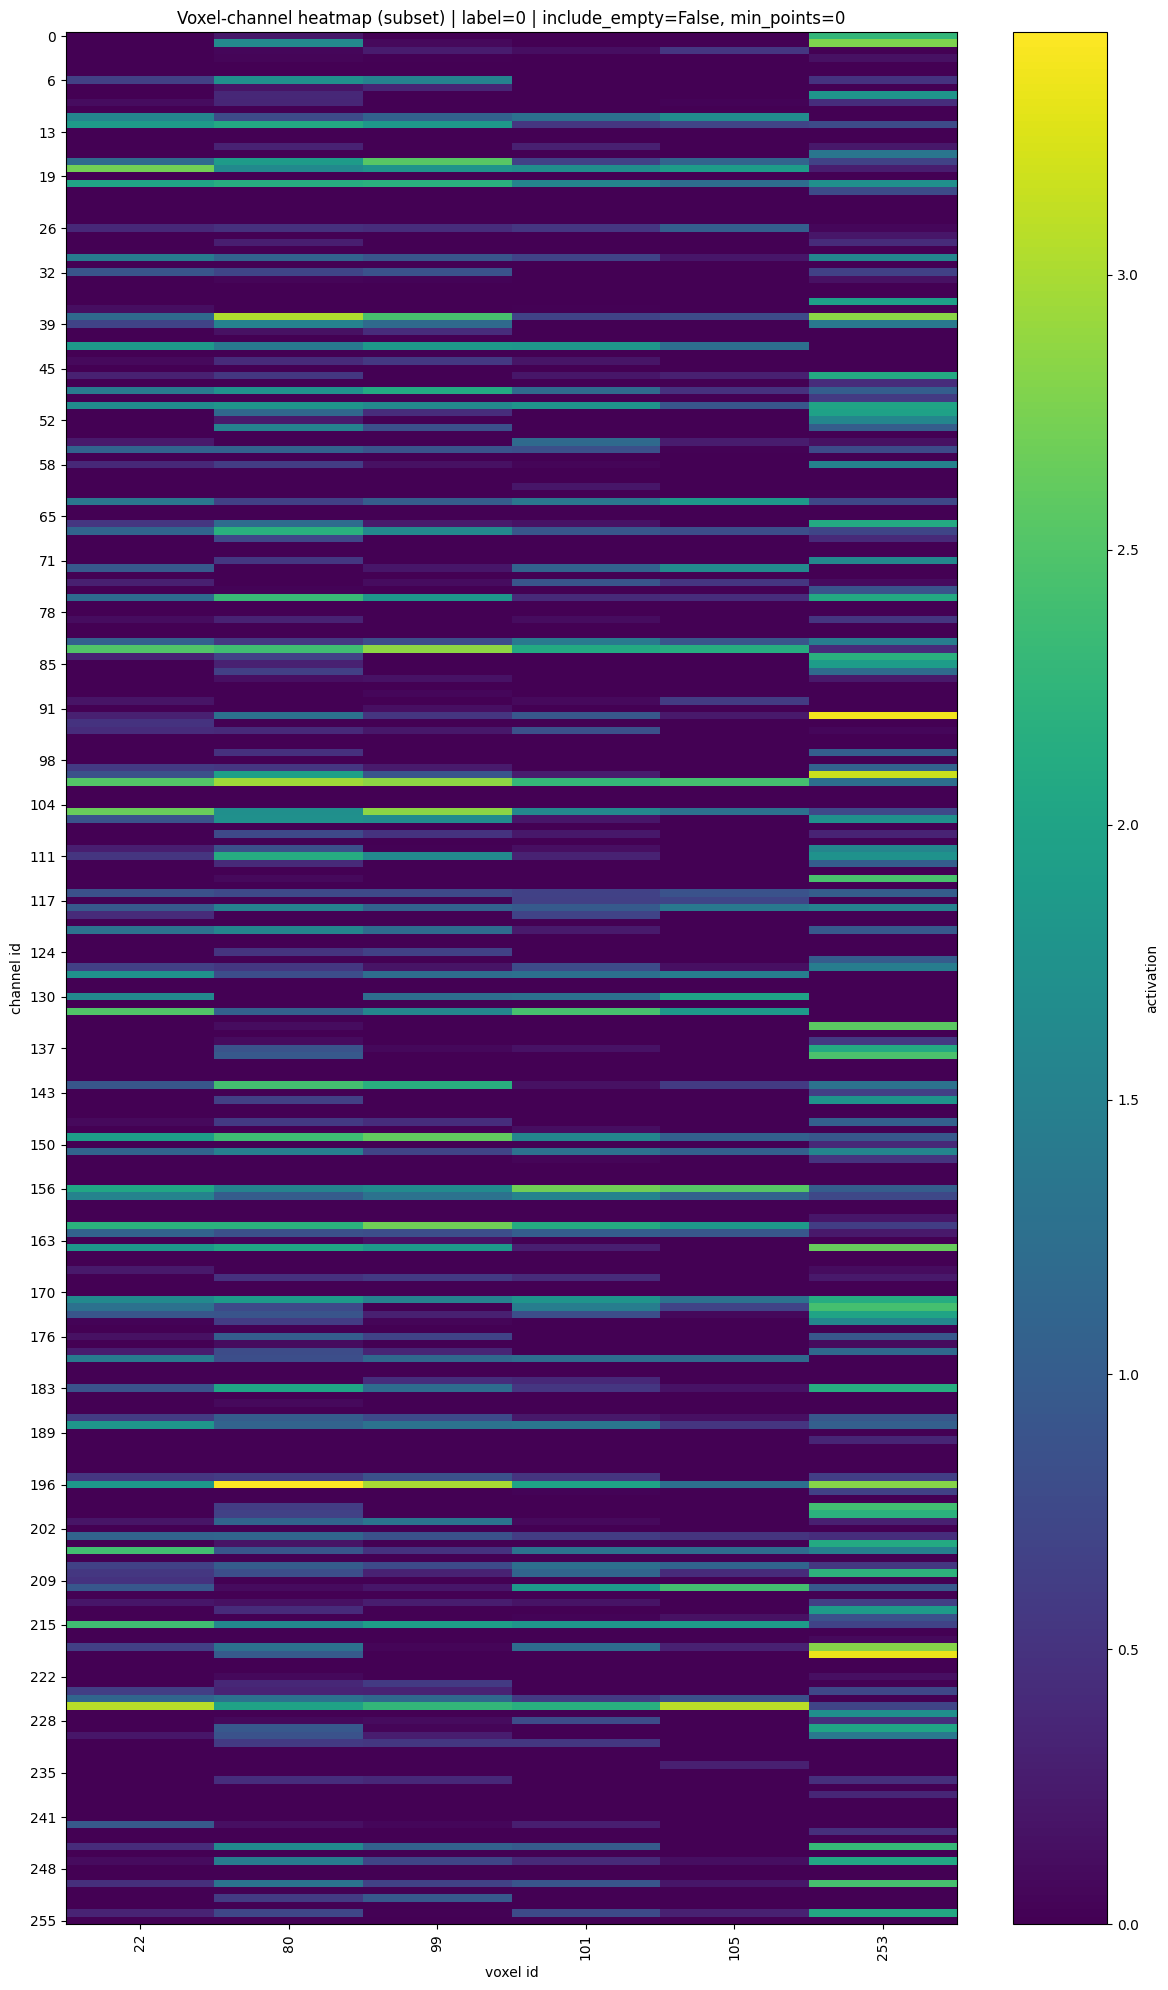

In [35]:
plot_voxel_channel_heatmap_subset(
    rec0,
    voxel_indices=point_counts_1,
    include_empty=False,
    min_points=0,
)


In [36]:
point_counts_50 = [idx for idx, numeber in enumerate(rec0['point_counts']) if numeber >= 50]
point_counts_50

[3,
 10,
 23,
 57,
 58,
 59,
 64,
 65,
 71,
 72,
 73,
 79,
 100,
 106,
 107,
 108,
 109,
 113,
 114,
 115,
 116,
 119,
 120,
 121,
 122,
 123,
 124,
 128,
 155,
 156,
 157,
 161,
 162,
 163,
 164,
 168,
 169,
 170,
 171,
 172,
 175,
 176,
 177,
 178,
 183,
 184,
 205,
 206,
 211,
 212,
 217,
 218,
 219,
 224,
 225,
 226,
 231,
 232,
 233,
 273,
 274,
 280,
 281,
 287,
 330,
 336,
 337]

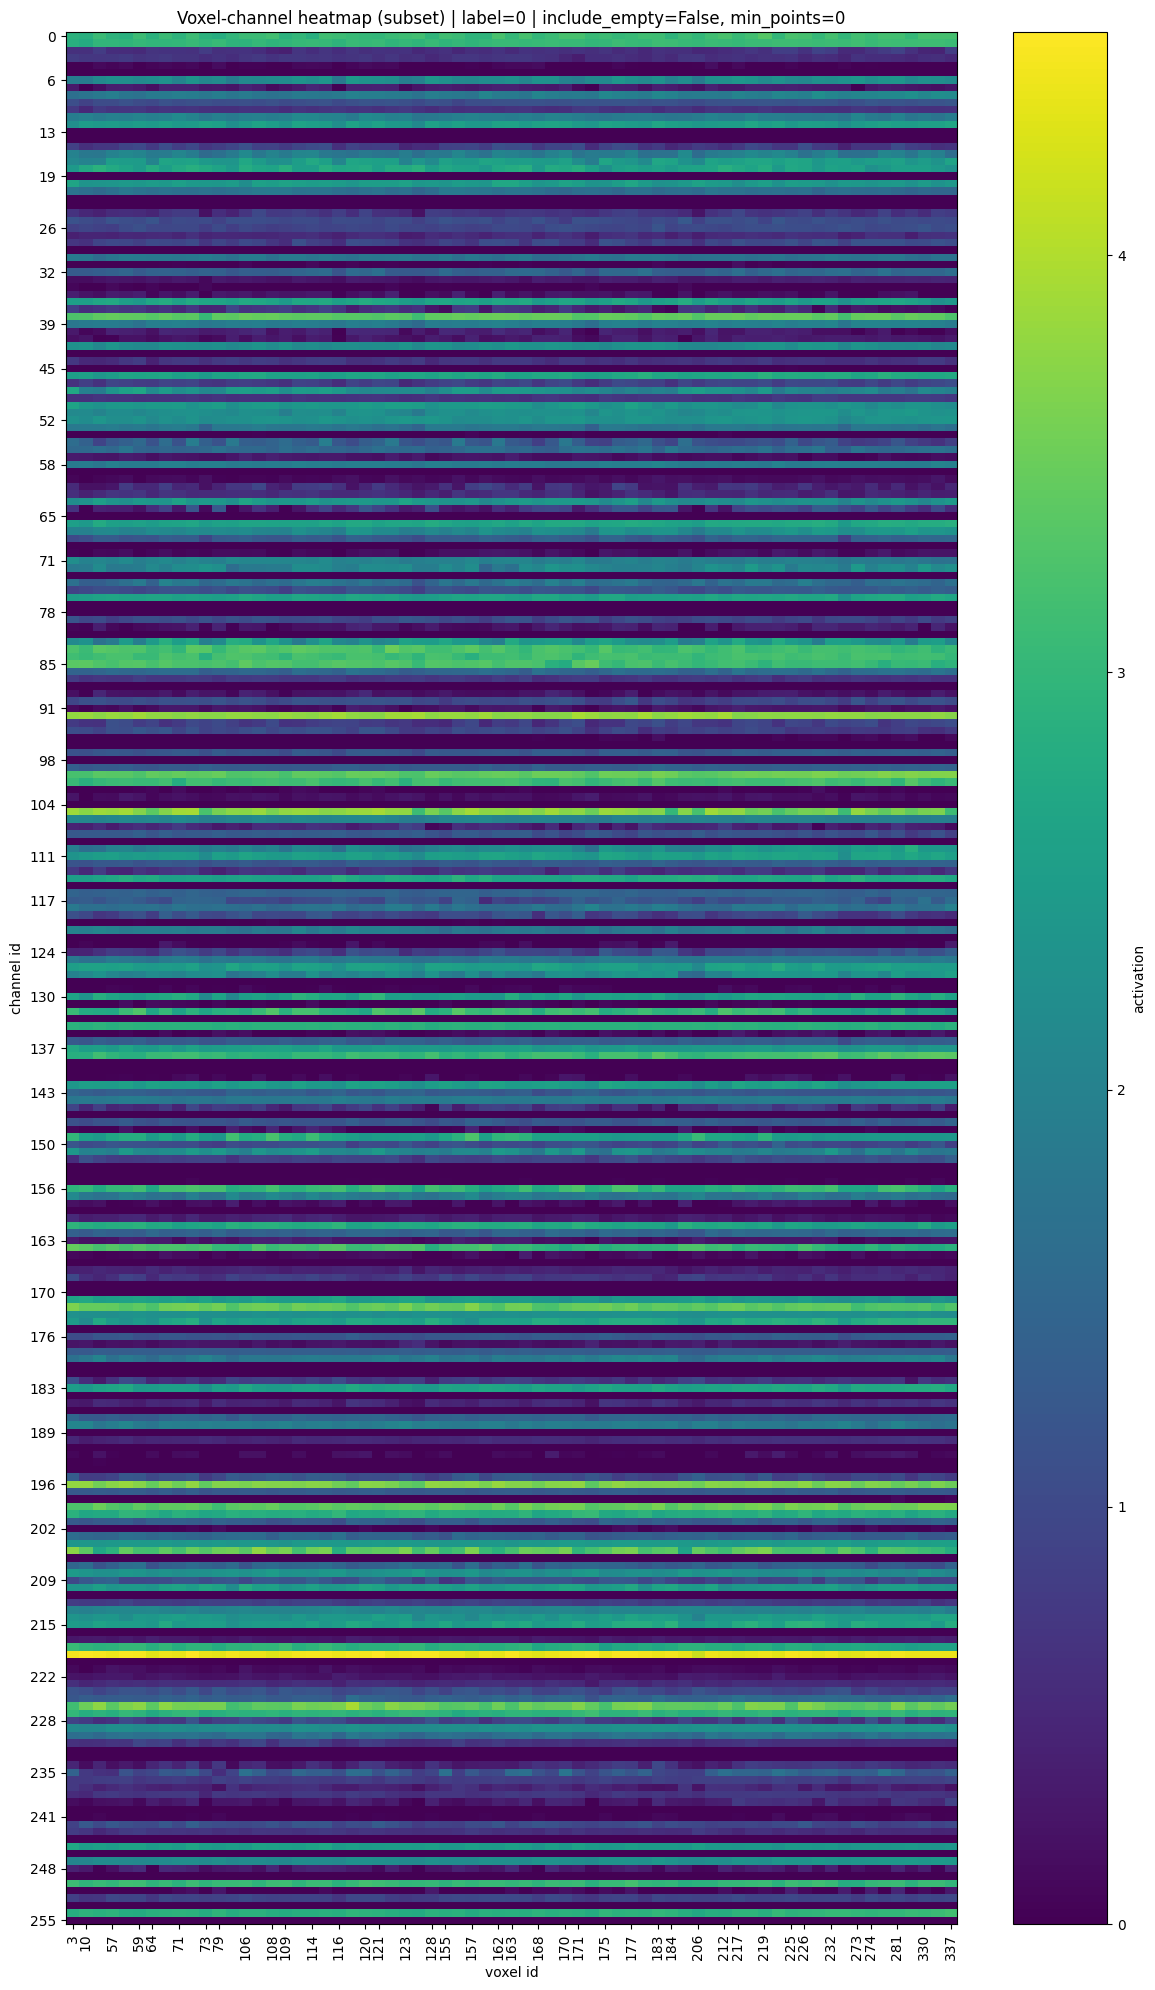

In [37]:
plot_voxel_channel_heatmap_subset(
    rec0,
    voxel_indices=point_counts_50,
    include_empty=False,
    min_points=0,
)


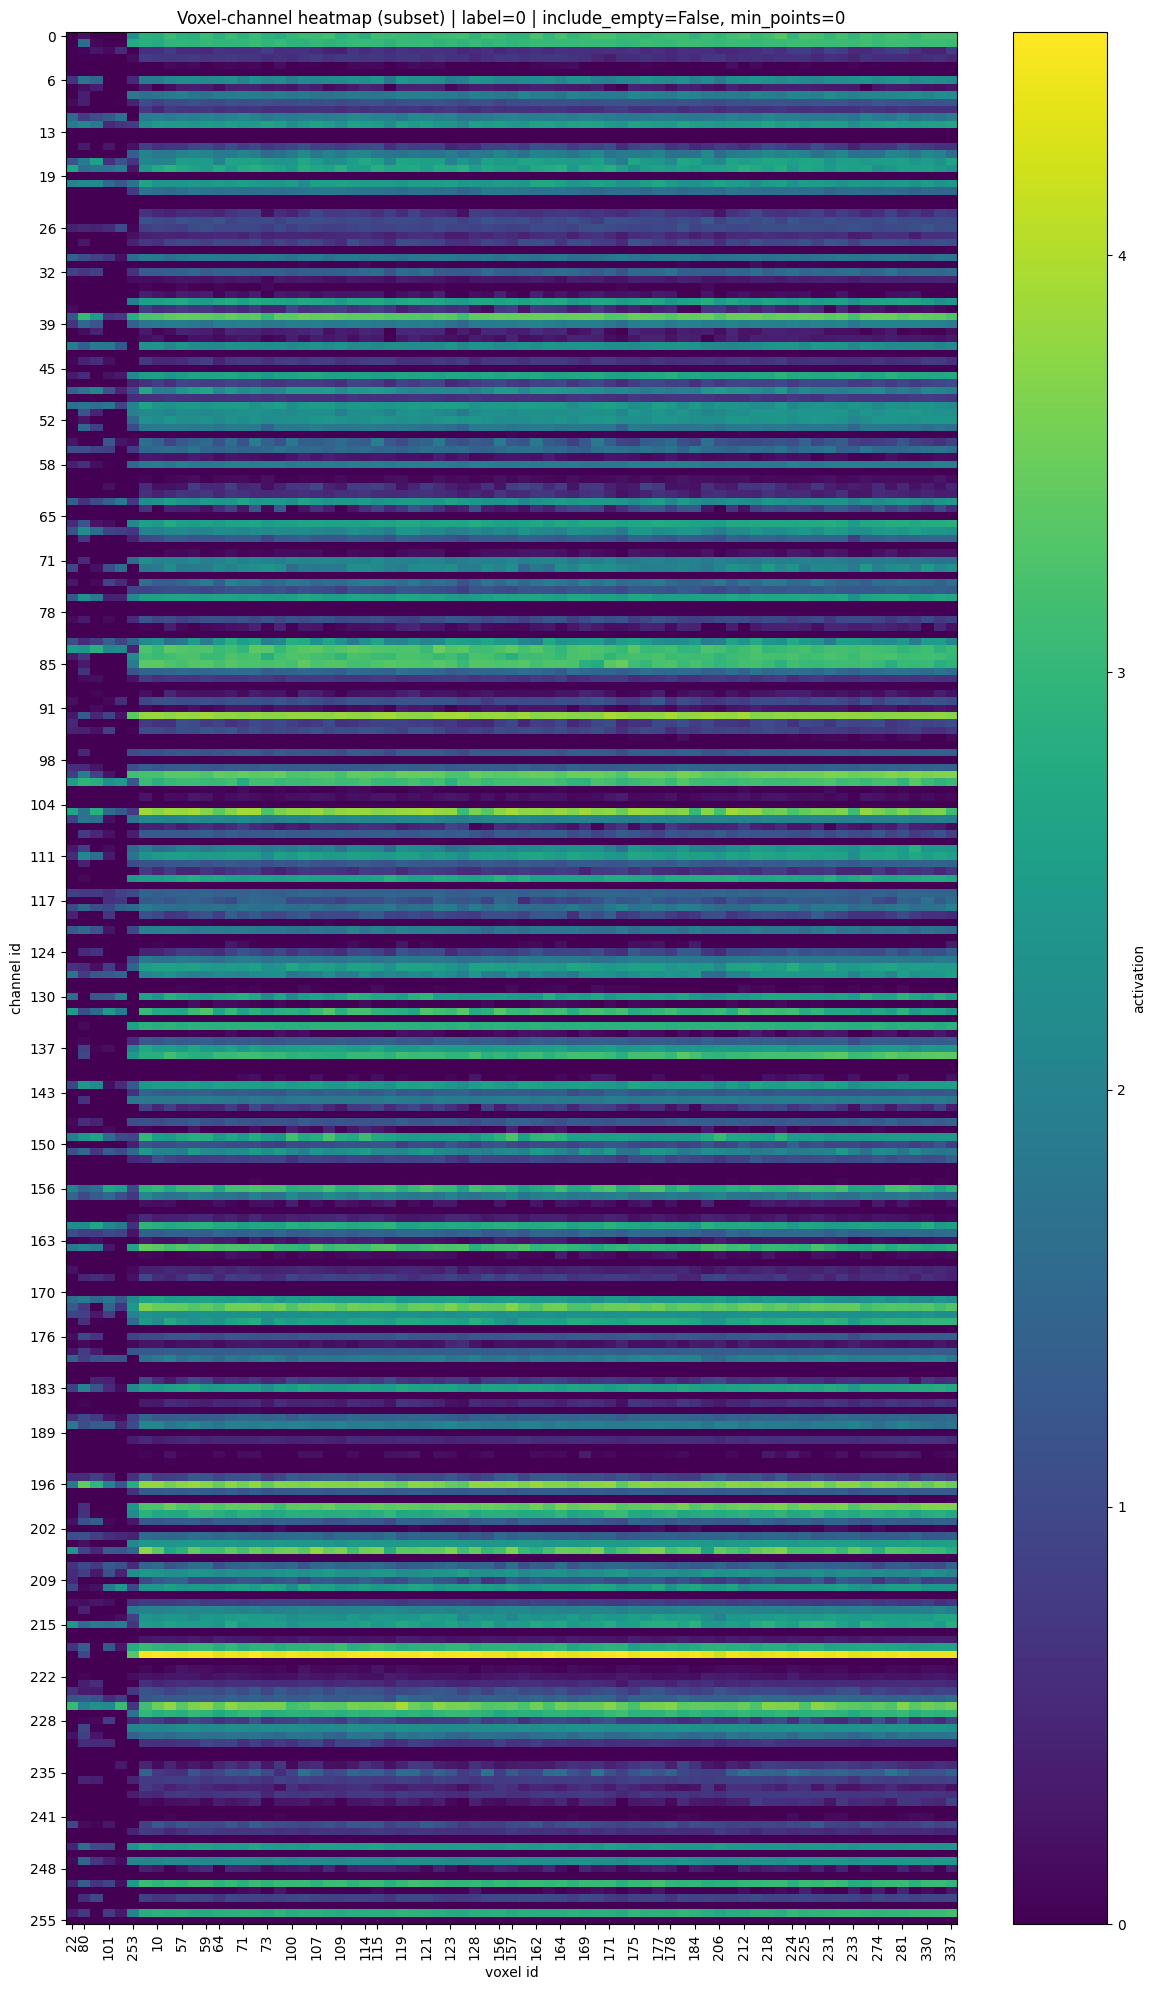

In [39]:
combined_point_clouts = point_counts_1 + point_counts_50
plot_voxel_channel_heatmap_subset(
    rec0,
    voxel_indices=combined_point_clouts,
    include_empty=False,
    min_points=0,
)
